# Defining all the constants required (copying them from Matlab and adjusting syntax)

In [1]:
from dolfin import *

#importing mshr for all mesh functions
import mshr as mshr

# Use SymPy to compute f from the manufactured solution u
import sympy as sym

#have to define where to put plots BEFORE importing matplotlib
%matplotlib notebook

#Importing matplotlib to plot the results
from matplotlib import pyplot as plt

#Importing numpy to work with arrays
import numpy as np

#Importing time to compute how long each segment takes
import time

#importing regex to change every instance of radius_tot so we change the ones in the C++ code
#at the same time too
import re

#varname gives the name of the variable as a string
from varname import varname

#Needed to use the 3D scatter
from mpl_toolkits.mplot3d import Axes3D

G = 6.674*10**(-11) 
a0 = 1.2*10**(-10) 
ms = 1.989*10**30 
mgd = 10**12*ms 
mgb = 1.1*6.6*10**10*ms
ly = 9.461*10**15 
kp = 3261.56*ly 
kpm = 20*kp 
au = 0.0000158*ly 
lst = 200*au 
lsu = 50*au 
lg = 52850*ly 
lgu = 40*10**3*ly 
lgb = 3*kp 
rs = 0.00465*au 
domain_size = 20*kp
radius_tot = 0.02*kp
radius_refine = radius_tot
volume_out = 4/3*pi*(radius_tot**3)
stand_dev = radius_tot/3
mesh_resolution = 21
refine_times = 15
p = 1*kp

In [2]:
#making a class for runtimes of each section to profile the program. it has a time and a name
#attribute, so when plotting we can directly use the name in e.g. a bar chart or pie chart
class run_time:
    
    #initialising class
    def __init__(self, time, name):
        self.time = time
        self.name = name

## Defining the initial mesh

In [58]:
## starting time of PDE solver
starting_time = time.time()
mesh_generation_start = time.time()

#starting an empty list to contain all of the run_time objects to plot later
section_times = []

print('Starting mesh generation...\n')
#Declaring the mesh as a sphere with an origin at (0,0,0) and radius domainsize
origin = Point(0,0,0)

#Defining the domain for the mesh using the Sphere function from mshr
domain = mshr.Sphere(origin, domain_size)

#Meshing the sphere generated with resolution 10 (cells per dimension)
mesh = mshr.generate_mesh(domain, mesh_resolution)

mesh_generation_end = time.time()
mesh_generation_time = run_time(mesh_generation_end - mesh_generation_start, 'Mesh Generation')
section_times.append(mesh_generation_time)
print('Mesh generated in {} s \n'.format(mesh_generation_time.time))

Starting mesh generation...

Mesh generated in 2.616319179534912 s 



# Using local mesh refinement after implementing a mesh function to mark individual cells to be refined based on some condition (page 187 of book)

In [4]:
def local_refinement (mesh, location, radius, how_many, technique = 'inside'):
    '''Function to refine mesh locally, based on the distance from a given point
    '''
    
    #Starting # cells before we refine, to compute growth factor
    starting_cells = mesh.num_cells()
    
    if how_many > 0:
    
        for i in range(how_many):

            #Initial mesh cell count
            initial_cells = mesh.num_cells()

            #We want to refine based on cell location, so we want to mark cells within a given radius
            #We create a MeshFunction containing a bool for each cell (3 stands for the topological
            #dimension, which is vertex->1, face->2, cell->3), on the given mesh
            cell_to_refine = MeshFunction("bool", mesh, 3)

            #Initialising all marker to false
            cell_to_refine.set_all(False)

            #Defining the point from which we want to perform the refinement
            origin_trial = location

            #cells(mesh_trial) is an iterator, so we can loop over it directly, without needing to know
            #anything about the cells
            for cell in cells(mesh):
                
                #With the close technique, we refine all cells with centers within a given radius
                if str(technique) == 'close':
                
                    #looking at the center of the cell
                    p = cell.midpoint()

                    #if the cell is within the required radius, we set the corresponding marker to True
                    if p.distance(origin) < radius:
                        
                        cell_to_refine[cell] = True

                elif technique == 'inside': 
                
                    if cell.contains(location):
                    
                        cell_to_refine[cell] = True

            #Refining the mesh only where the markers are True, so inside the desired radius 
            mesh = refine(mesh, cell_to_refine)

            final_cells = mesh.num_cells()
            
            partial_growth_factor = final_cells/initial_cells
            
            print(('Iteration {} of {}: The Cell number went from {} to {}, up by a factor {}\n'
                  .format(i+1, how_many, initial_cells, final_cells, partial_growth_factor)))
    
        #ratio between # cells at beginning and end of refinement
        total_growth_factor = final_cells/starting_cells

        print('Cell number went up by a factor {}\n'.format(total_growth_factor))
    
    #returning the refined mesh
    return mesh

In [60]:
print('Starting mesh refinement...\n')
mesh_refine_start = time.time()
mesh = local_refinement(mesh, origin, radius_refine, refine_times, technique = 'inside')
mesh_refine_end = time.time()
mesh_refine_time = run_time(mesh_refine_end - mesh_refine_start, 'Mesh Generation')
section_times.append(mesh_refine_time)
print('Mesh refined in {} s \n'.format(mesh_refine_time.time))

Starting mesh refinement...

Iteration 1 of 15: The Cell number went from 32135 to 32627, up by a factor 1.0153104092111405

Iteration 2 of 15: The Cell number went from 32627 to 33355, up by a factor 1.0223128084102124

Iteration 3 of 15: The Cell number went from 33355 to 34675, up by a factor 1.039574276720132

Iteration 4 of 15: The Cell number went from 34675 to 36021, up by a factor 1.038817591925018

Iteration 5 of 15: The Cell number went from 36021 to 36343, up by a factor 1.0089392298936732

Iteration 6 of 15: The Cell number went from 36343 to 36947, up by a factor 1.0166194315273918

Iteration 7 of 15: The Cell number went from 36947 to 38341, up by a factor 1.0377297209516334

Iteration 8 of 15: The Cell number went from 38341 to 39137, up by a factor 1.0207610651782686

Iteration 9 of 15: The Cell number went from 39137 to 40059, up by a factor 1.023558269668089

Iteration 10 of 15: The Cell number went from 40059 to 40542, up by a factor 1.0120572156069798

Iteration 11 

# Finding the cell containing a given point using a mesh function

In [6]:
def contains_source (mesh, point):
    
    
    #Defining the function to determine whether the source is inside the cell
    source_inside = MeshFunction('bool', mesh, 3)
    
    #Setting it to False for each cell to initialise
    source_inside.set_all(False)
    
    #Iterating over the cells(mesh) iterable
    for cell in cells(mesh):
        
        #Checking if the point is inside the cell with the contains() method
        if cell.contains(point):
            
            #If the cell contains the point, then mark it True and get its volume 
            source_inside[cell] = True
            source_volume = cell.volume()
            
            #If found, leave the for loop as for now only one source
            break
    
    return source_volume          

In [7]:
#Obtaining the volume of the cell containing the source
# source_volume = contains_source(mesh, origin)

## Gathering all the data from the mesh AFTER having done the mesh refinement

In [8]:
#Declaring the function space on the mesh, where 'P',1 means  linear Lagrangian elements
V = FunctionSpace(mesh, 'CG', 1)

#Finding the total number of vertices in the mesh
vertex_number = mesh.num_vertices()

#Storing x, y, z coordinates of each point of the mesh in a separate numpy array
x_coords = mesh.coordinates()[:,0]
y_coords = mesh.coordinates()[:,1]
z_coords = mesh.coordinates()[:,2]

#using the numpy linalg.norm function to get the radius(norm) of each vertex
r_coords = np.linalg.norm(mesh.coordinates(), axis=1)

#Storing the index to sort according to r
sorting_index = r_coords.argsort()

#Sorted radial distances
r_sorted = r_coords[sorting_index]

#Sorted coordinates
x_sorted = x_coords[sorting_index]
y_sorted = y_coords[sorting_index]
z_sorted = z_coords[sorting_index]

#Need to get the coordinates closest to a point (here the origin) to use in the c++ expression
x_close = x_sorted[0]
y_close = y_sorted[0]
z_close = z_sorted[0]
r_close = r_sorted[0]

Mesh generated in 4.278422117233276s 



## Defining sources and related initial guesses for different cases (c++ syntax)

In [9]:
#VERY IMPORTANT: Each constant used in declaring an expression in c++ code needs to be
#declared inside Expression, after the degree! If not, the c++ compiler will throw an error!
#IMPORTANT!: Cannot use the log function cause that name is apparently already taken by some
#other function, not the logarithm! So using log10 and rescaling by 0.43429.
#IMPORTANT!! When changing the radius_tot in the above script is doesn't change in here cause
#it has to be defined independently for all of these C++ expressions! If you don't change it 
#inside here for both u and f, the solution will be wrong!

#Sphere of constant density
#Using separate '...' on each line so I can write the C++ code over multiple lines, less messy
f_sphere_cpp = ('(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))<=pow(radius_tot, 2) ?'
'a0*4*pi*G*mgb/volume_out : 0')

u_sphere_cpp = ('(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))>=pow(radius_tot, 2) ?'
'sqrt(G*mgb*a0)*1/2*2.3026*log10(pow(x[0],2)+pow(x[1],2)+pow(x[2],2)) :'
'(4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*pow((pow(x[0],2)+pow(x[1],2)+pow(x[2],2)),3/4)+'
'sqrt(G*mgb*a0)*2.3026*log10(radius_tot)-4/3*sqrt(pi/3*a0*G*mgb/volume_out)*'
'3/2*pow(radius_tot,3/2))')

# Dirac Delta function using conditional for each coordinate (doesnt work)
f_dirac_coord_cond_cpp = ('(abs(x[0]-x_close) <= x_close && '
                                   'abs(x[1]-y_close) <= y_close && '
                                   'abs(x[2]-z_close) <= z_close)  ? '
                                   'a0*4*pi*G*mgb: 0')

#Dirac delta using very small radius (doesnt work)
f_dirac_radius_cond_cpp = ('pow(x[0],2) + pow(x[1],2) + pow(x[2],2) <= 2*pow(radius_close,2)'
                           ' ? mgb : 0')

#Dirac Delta using definition (as suggested here https://fenicsproject.org/qa/7941/applying-
#dirac-function-using-fenics-pointsource-function/)
f_dirac_analytic1_cpp = ('a0*4*pi*G*mgb*eps/pi*1/(pow(x[0],2) + pow(x[1],2) + pow(x[2],2) + pow(eps,2))')

u_dirac_cpp = ('sqrt(G*mgb*a0)*1/2*2.3026*log10(pow(x[0],2)+pow(x[1],2)+pow(x[2],2))')

#Defining a Gaussian pulse with a standard deviation radiustot/3, so 99.7% of mass is inside
#radius tot and we can compare with the analytic solution for a sphere
f_gauss_cpp = ('a0*4*pi*G*mgb*(1/pow((stand_dev*sqrt(2*pi)),3))*exp(-(1/2)*((pow(x[0]-x_close ,2)'
               '+ pow(x[1] - y_close,2) + pow(x[2] - z_close,2))/(pow(stand_dev,2))))')

#Defining the source and initial guess for an isothermal distribution
f_isothermal_cpp = ('a0*4*pi*G*3*mgb/(4*pi)*pow((pow(p, 1/2)/(pow(p, 3/2) +'
                    'pow((pow(x[0],2) + pow(x[1],2) + pow(x[2],2)), 3/4))), 3)')

u_isothermal_cpp = ('2/3*sqrt(G*mgb*a0/6)*2.3206*log10(1 + pow((pow(x[0],2) + '
                    'pow(x[1],2) + pow(x[2],2)), 3/4) / pow(p, 3/2))')

#Testing the exponential function in the source cause it doesnt seem to work, THIS WORKS!
#APART FROM HAVING SLIGHTLY MORE MASS THAN IT SHOULD!
f_exponent_test = ('a0*4*pi*G/pow(2*pi,3/2)*mgb/pow(stand_dev,3)*exp(-(pow(x[0],2) + pow(x[1],2) + pow(x[2],2))/(2*(pow(stand_dev,2))))')

# Solving the PDE using FEniCS

In [10]:
## starting time of PDE solver
starting_time = time.time()
print('Defining coefficients...\n')

#defining the x,y,z coordinates from the coordinate array in sympy
x, y, z = sym.symbols('x[0], x[1], x[2]')

#VERY IMPORTANT: If using sympy, use sym. in front of every mathematical operator, or the sym. and UFL (the
#mathematical syntax used in fenics) collide and an error about UFL conversion appears

#using u for the BC. If using it with coordinates it gives compiler errors. But for spherical
#symmetry the BC is constant on the boundary so we can use this
u_D = sym.sqrt(G*mgb*a0)*sym.ln(domain_size)

#IMPORTANT: we can first define our sources / nonlinear terms in Python (using sympy)
#Then, we convert them from sympy to c++ syntax since DOLFIN generates C++ code. 

#the gaussian source does not reach convergence. Trying with a conditionally declared
#source as a uniform sphere

#Checking the point is the correct one within a tolerance epsilon

# Declaring the expression for the source
f = (Expression(f_exponent_test,
degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
volume_out = volume_out, x_close = x_close, y_close = y_close, z_close = z_close,
radius_close = r_close, eps = 3*pow(10,5), stand_dev = stand_dev, p=p))

#Defining f as a point source with Alice's method
# f = Function(V)

# source_origin = Point(x_close, y_close, z_close)
# source_origin = origin

# delta = PointSource(V, source_origin, a0*4*pi*G*mgb/source_volume)

# delta.apply(f.vector())

#Declaring the expression for the initial guess
u = (Expression(u_dirac_cpp,
degree = 0, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
volume_out = volume_out, p=p))

coefficients_end = time.time()
#Defining a run_time object for the time taken for each section, here for the coefficients
coefficients_time = run_time(coefficients_end - starting_time, 'Setting Coefficients')

#starting an empty list to contain all of the run_time objects to plot later
section_times = []

#appending the first run_time object to the list
section_times.append(coefficients_time)

print('Coefficients set in {}s\n'.format(coefficients_time.time))

print('Starting mesh generation...\n')

# #Trying to define a delta function directly
# delta = PointSource(V, origin, 4*pi*G*mgb)

#Defining a function for the boundary. Since we only have one BC for the whole boundary, we
#can make a simple function that returns true for each value on the boundary
#the on_boundary built-in function takes each point in domain and returns true if on boundary
def boundary(x, on_boundary):
    return on_boundary

#Declaring the boundary condition. It takes three arguments: function space, value of BC, 
#section of the boundary (in our case the whole boundary).
bc = DirichletBC(V, u_D, boundary)

mesh_end = time.time()
mesh_time = run_time(mesh_end - coefficients_end, 'Mesh Generation')
section_times.append(mesh_time)
print('Mesh generated and BC done in {}s \n'.format(mesh_time.time))

print('Solving PDe...\n')

#Defining the variational problem
#u is the solution. for linear problems, we'd have to define it as TrialFunction, but for 
#non-linear we define it as Function directly
u = interpolate(u, V)

#defining the test function
v = TestFunction(V)

#defining the weak form to be solved
F = inner(sqrt(inner(grad(u), grad(u))) * grad(u), grad(v))*dx + f*v*dx

#Computing the solution
(solve(F == 0, u, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6},
                                         "newton_solver":{"maximum_iterations":200}}))

solver_end = time.time()
solver_time = run_time(solver_end - mesh_end, 'PDE Solver')
section_times.append(solver_time)
PDE_time = solver_end - starting_time

print('PDE solved in {}\n'.format(solver_time.time))
print('Overall time taken: {}s'.format(PDE_time))

Defining coefficients...

Coefficients set in 0.004221916198730469s

Starting mesh generation...

Mesh generated and BC done in 0.0003857612609863281s 

Solving PDe...

PDE solved in 1.1612658500671387

Overall time taken: 1.1658735275268555s


# Plots
## First, the potential

### Defining a function to set x,y,z axes labels and ticks

In [11]:
def plot_format(dimension, *args):
    plt.legend()
    plt.tight_layout()
    plt.grid()
    #*args gives an arbitrary # of inputs. we take the 1st one to define if the plot is radial
    #if it is (=1), we only need to plot from 0, not -domainsize
    if args[0] == 0:
        plt.xlabel('x (kpc)')
        plt.xticks(np.linspace(-domain_size,domain_size,11))
    else:
        plt.xlabel('r (kpc)')
        plt.xticks(np.linspace(0,domain_size,11))
    if dimension == 2:
        plt.ylabel('y (kpc)')
        plt.yticks(np.linspace(-domain_size,domain_size,11))
    elif dimension == 3:
        plt.zlabel('z (kpc)')
        plt.zticks(np.linspace(0,domain_size,11))
    else:
        None

### Defining a function to add useful annotations to radial graphs

In [12]:
def plot_annotations():
    #Adding a vertical line to denote the end of the mass distribution
    plt.axvline(x = radius_tot, color = 'k', linestyle = '-.', linewidth = 1, label = 'Mass Density')

    #and another to signal where the transition between Newton and MOND occurs
    plt.axvline(x = sqrt(G*mgb/a0), color ='k',linestyle ='--',linewidth = 1,label = 'Transition')

In [13]:
# start_potential_plot = time.time()
# print('Generating potential plot...\n')
# plt.figure()
# plot(u, title = 'Potential')
# # plot_format(2)
# # plt.xlabel('x')
# # plt.ylabel('y')
# plt.tight_layout()
# end_potential_plot = time.time()
# time_potential_plot_3D = run_time(end_potential_plot - start_potential_plot, '3D Potential Plot')
# section_times.append(time_potential_plot_3D)
# print('Potential plot generated in {}s'.format(time_potential_plot_3D.time))

## Then, the gradient

In [14]:
# start_acceleration_plot = time.time()
# print('Generating acceleration plot...\n')
# plt.figure()
# plot(grad(u), title = 'Acceleration')
# end_acceleration_plot = time.time()
# time_acceleration_plot_3D = run_time(end_acceleration_plot-start_acceleration_plot, '3D Acceleration Plot')
# section_times.append(time_acceleration_plot_3D)
# print('Acceleration plot generated in {}s...\n'.format(time_acceleration_plot_3D))

## Finding the values of the function, its gradient and the source at each vertex of the mesh, and the coordinates at each point of the mesh

In [15]:
start_data_collection = time.time()

#The value of the function at each vertex of the mesh is stored in a np array. Its order
#corresponds to the otder of the mesh.coordinates() values
potential = u.compute_vertex_values()

#The value of the source at each vertex of the mesh
source = f.compute_vertex_values(mesh)

#Getting the degree from the scalar function space V from the PDE
degree = V.ufl_element().degree()

#To obtain the values for the acceleration, we need to define a new function space, since the 
#gradient is a vector function is the function space for the PDE is a scalar function space
W = VectorFunctionSpace(mesh, 'P', degree)

#Projecting (similar to interpolating) the grad(u) field onto W, gives a function
acceleration = project(grad(u), W)

#The result of project is n*3,1 np.array, with 3 (x,y,z) values for each of the n vertices
acceleration = acceleration.compute_vertex_values()

#reshaping the array to split the x,y,z components into their own column each
acceleration = np.reshape(acceleration, (3, int(acceleration.shape[0]/3)))

#Finding the magnitude of the acceleration
acceleration_magnitude = np.linalg.norm(acceleration, axis=0)

#Sorting the potential, acceleration and source according to thr r of the vertex they pertain to
potential_sorted = potential[sorting_index]
acceleration_magnitude_sorted = acceleration_magnitude[sorting_index]
source_sorted = source[sorting_index]

end_data_collection = time.time()
data_collection_time = run_time(end_data_collection - start_data_collection, 'Data Collection')
section_times.append(data_collection_time)

In [16]:
acceleration.shape

(3, 6610)

## Plotting radially
## First, the potential

<IPython.core.display.Javascript object>


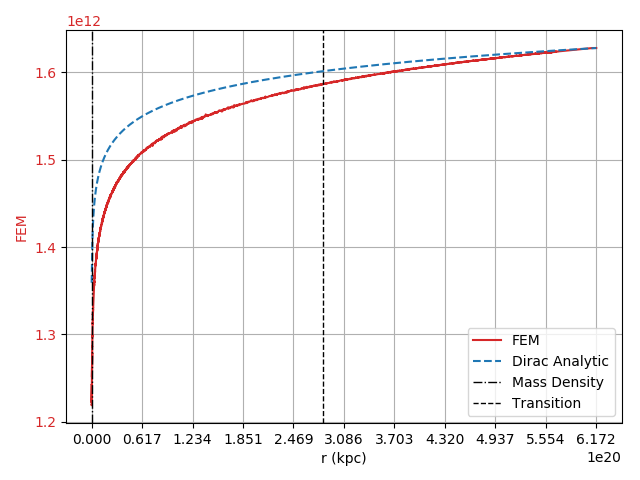

In [17]:
start_radial_plots = time.time()

#Defining analytic functions to check if the result is correct
#2nd argument of Heaviside is its value where the Heaviside goes from 0 to 1
potential_sphere_analytic = (np.heaviside(r_sorted - radius_tot, 0.5)*sqrt(G*mgb*a0)*np.log(r_sorted) +
(np.heaviside(radius_tot - r_sorted, 0.5))*(4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*np.power(r_sorted,3/2)+
sqrt(G*mgb*a0)*ln(radius_tot) - 4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*radius_tot**(3/2)))

#Analytic potential on the inside of a sphere
potential_inside_analytic = (4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*np.power(r_sorted,3/2)+
sqrt(G*mgb*a0)*ln(radius_tot) - 4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*radius_tot**(3/2))

#Analytic potential for a Dirac Delta
potential_dirac_analytic = sqrt(G*mgb*a0)*np.log(r_sorted)

#Analytic potentials for isothermal distribution
potential_isothermal_analytic = 2/3*sqrt(G*mgb*a0/6)*np.log(1 + np.power(r_sorted, 3/2)/p**(3/2))

#Plotting radial FEM solution and analytic solution on the same plot. We use subplots so'
#we can put multiple axes on the same plot and plot different scales
fig, potential1 = plt.subplots()

color = 'tab:red'
potential1.set_ylabel('FEM', color=color)

potential1.plot(r_sorted, potential_sorted, label = 'FEM', color=color)

potential1.tick_params(axis='y', labelcolor=color)

#UNCOMMENT TO HAVE SEPARATE AXES TO COMPARE SHAPES
# potential2 = potential1.twinx()
color = 'tab:blue'
# potential2.set_ylabel('Analytic', color=color)
plt.plot(r_sorted, potential_sphere_analytic, label = 'Dirac Analytic', linestyle = '--')
# potential2.plot(r_sorted, potential_sphere_analytic, label = 'Dirac Analytic', linestyle = '--', color=color)

#It is possible to use Latex directly in the labels by enclosing expressions in $$
# plt.ylabel('$\phi$')

plot_annotations()

#Formatting plot using the function I made
plot_format(1,1)

## Finding the error in the potential, radially

<IPython.core.display.Javascript object>


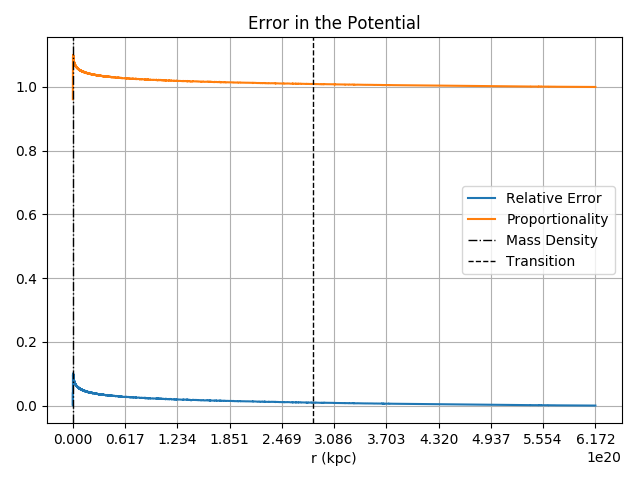

In [18]:
#for spherically symmetric mass distributions we have the anlytic solution, so we can compute
#the error
potential_error = np.abs((potential_sorted - potential_dirac_analytic)/potential_sorted)
potential_proportionality = potential_dirac_analytic/potential_sorted

#plotting the error against the radius
plt.figure()
plt.plot(r_sorted,potential_error, label = 'Relative Error')
plt.plot(r_sorted,potential_proportionality, label = 'Proportionality')
plt.title('Error in the Potential')
plot_annotations()
plot_format(1,1)

# Looking at the value of the potential along a specific axis. Useful when dealing with a non-radially symmetric distribution

<IPython.core.display.Javascript object>


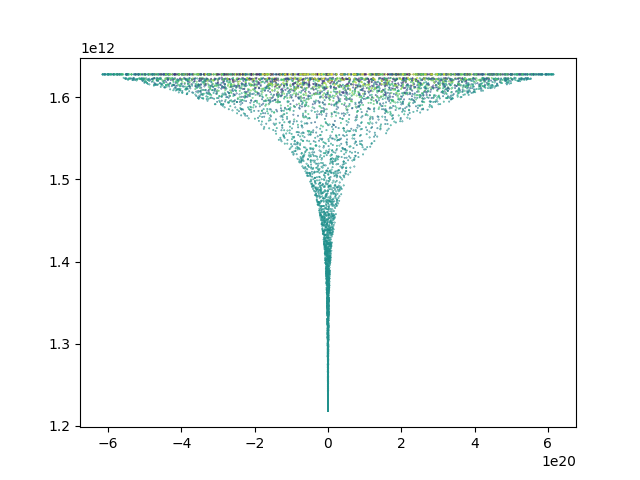

In [19]:
plt.figure()

plt.scatter(x_coords, potential, marker = '.', s = 0.5, c = y_coords/y_coords.max())


## Next, the acceleration

<IPython.core.display.Javascript object>


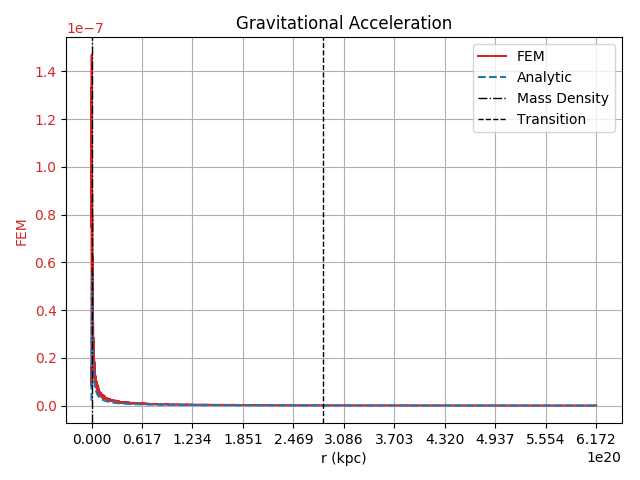

In [20]:
#Defining analytic functions to check if the result is correct
#2nd argument of Heaviside is its value where the Heaviside goes from 0 to 1
acceleration_sphere_analytic = (np.heaviside(r_sorted - radius_tot, 0.5)*sqrt(G*mgb*a0)*1/r_sorted+
(np.heaviside(radius_tot-r_sorted, 0.5))*4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*np.sqrt(r_sorted))

acceleration_dirac_analytic = sqrt(G*mgb*a0)*1/r_sorted

fig, acceleration1 = plt.subplots()

color = 'tab:red'
acceleration1.set_ylabel('FEM', color=color)

acceleration1.tick_params(axis='y', labelcolor=color)

#Plotting radial FEM solution and analytic solution on the same plot
acceleration1.plot(r_sorted, acceleration_magnitude_sorted, label = 'FEM', color = color)

#UNCOMMENT TO HAVE SEPARATE Y AXES
# acceleration2 = acceleration1.twinx()
color = 'tab:blue'
# acceleration2.set_ylabel('Analytic', color=color)

plt.plot(r_sorted, acceleration_sphere_analytic, label = 'Analytic', linestyle = '--', color = color)
plt.title('Gravitational Acceleration')

plot_annotations()

#Formatting plot using the function I made
plot_format(1,1)

## Finding the error in the acceleration

<IPython.core.display.Javascript object>


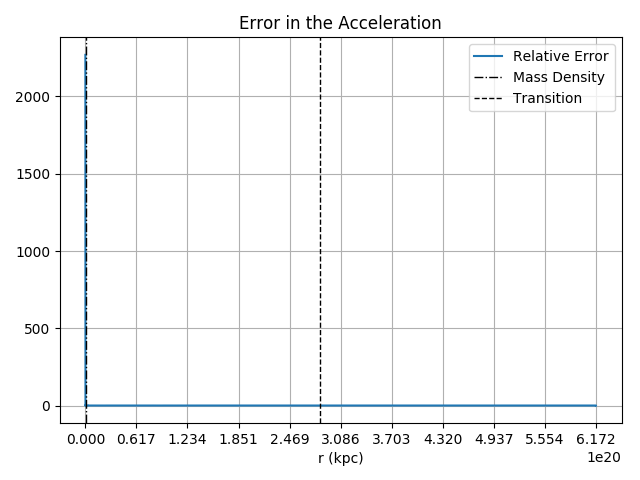

In [21]:
#for spherically symmetric mass distributions we have the anlytic solution, so we can compute
#the error
acceleration_error = np.abs((acceleration_magnitude_sorted - acceleration_dirac_analytic)/acceleration_magnitude_sorted)

#plotting the error against the radius
plt.figure()
plt.plot(r_sorted,acceleration_error, label = 'Relative Error')
plt.title('Error in the Acceleration')
plot_annotations()
plot_format(1,1)

end_radial_plots = time.time()
radial_plots_time = run_time(start_radial_plots - end_radial_plots, 'Radial Plots')
section_times.append(radial_plots_time)

## Plotting the source to check its value

<IPython.core.display.Javascript object>


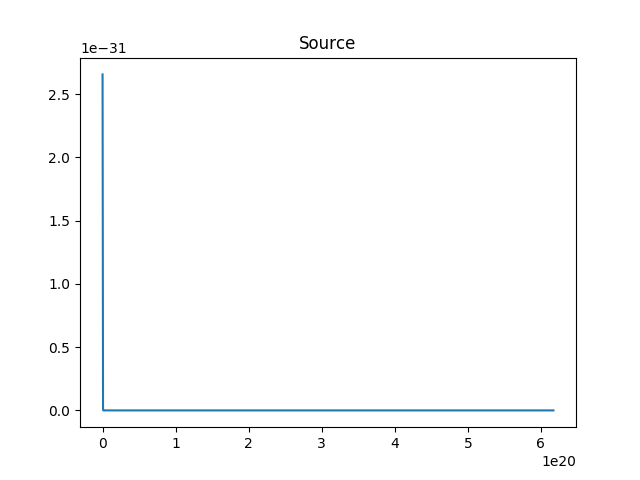

Text(0.5, 1.0, 'Source')

In [22]:
plt.figure()
plt.plot(r_sorted, source_sorted)
plt.title('Source')

## Histogram to look at the radial vertex distribution
### First, defining the function to do this

In [23]:
def radial_dist_hist(mesh, density, bins):
    
    #Having independent y axes so we don't need to adjust the function to compare the scaling 
    fig, histo = plt.subplots()
    color = 'tab:blue'
    histo.set_ylabel('radial distance density', color=color)
    histo.tick_params(axis='y', labelcolor=color)
    
    #Looking at how the points are distributed radially. If they are uniform, their density
    #should increase with r^2 due to sphere surface
    #plotting histogram of point density radially
    to_hist = histo.hist(r_coords, density=density, bins=bins, label = 'distribution', color = color)
    
    #Adding the value of each bin on top of the bin
    for i in range(bins):
        plt.text(to_hist[1][i],to_hist[0][i],str(int(to_hist[0][i])))
    
    #Putting the grid with the histogram values as those are the interesting quantities
    plt.grid()
    
    #Second y axis
    quadratic = histo.twinx()
    color = 'tab:orange'
    quadratic.set_ylabel('Quadratic', color=color)
    quadratic.tick_params(axis='density', labelcolor=color)
    
    #plotting a cubic relation, scaled by the max element^3 to be of order unity
    quadratic.plot(r_sorted, np.power(r_sorted,2), label = 'quadratic', color = color)
    
    #Forcing the lower limit in both plots to 0 so there's no offset
    plt.ylim(bottom=0)
    
    plt.tight_layout()
    plt.legend()

### Applying the function to the generated mesh

<IPython.core.display.Javascript object>


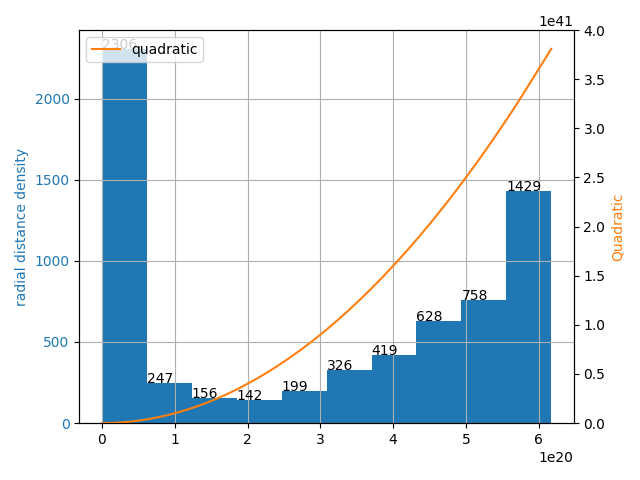

In [24]:
radial_dist_hist(mesh, False, 10)

## For non spherically symmetric meshes, and for visual clarity, taking a slice of the mesh and plotting it in 2D

## First, a 3D view of the mesh vertices

In [25]:
def plot_mesh(figure, vertex_fraction, color, show_mesh = False, alpha = 0.3):
    '''
    Plotting the first vertex_number/vertex_fraction points of the mesh, based on radial
    distance. Need to input a figure name of format figure = plt.figure() for the subplot
    to work. Through this, we can embed this plot into other plots. Adding optional mesh and
    alpha inputs.
    '''
    
    #Getting the number of vertices required as an intege of the fraction given
    how_many = int(vertex_number/vertex_fraction)
    
    #projection='3d' needed to specify a 3D scatter plot
    mesh_scatter = figure.add_subplot(111, projection='3d')
    
    #plotting the total/vertex_fraction closest vertices to the origin
    #s gives the size of the dots, multiplying it by vertex_fraction so when we have less dots
    #we can make them more visible
    (mesh_scatter.scatter(x_sorted[0:how_many], y_sorted[0:how_many], z_sorted[0:how_many],
                         marker = '.', s=1*vertex_fraction, c = color))
    
    #Adding optional to show the mesh at the same time
    if show_mesh:
        plot(mesh, alpha = alpha, color = 'w')
    else:
        pass

<IPython.core.display.Javascript object>


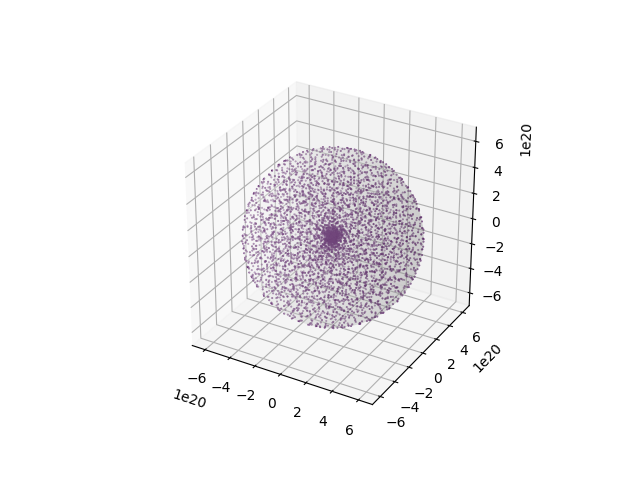

In [44]:
#Have to first declare a figure and use its name as an input to the function
#This way the plot can be plotted alongside other plots on the same grid
whole_mesh = plt.figure()

#Plotting the points 
plot_mesh(whole_mesh, 1, acceleration_magnitude_sorted, show_mesh=True, alpha = 0.2)

## Obtaining a slice of mesh points close to the xy plane

In [27]:
def slice_mesh(amount, mesh, height = 0, portion = True, values = True, *args):
    '''Selecting only points of the mesh that are close to the xy plane. First, sorting points
    according to their z coordinate, then selecting either amount # of them or a portion of the
    total, dpeending on 'portion'. Optionally output a function args[0] at those points
    '''
    
    #Getting abs(z), distance from xy plane, and getting the index that sorts this new array
    xy_plane_distance = np.abs(z_coords - height)
    
    #index of points sorted by distance from xy plane (absolute value of z coordinate)
    z_sorting_index = xy_plane_distance.argsort()
    
    #x,y,z coordinates of point sorted by distance from xy plane
    z_xy_plane = z_coords[z_sorting_index]
    x_xy_plane = x_coords[z_sorting_index]
    y_xy_plane = y_coords[z_sorting_index]
    
    #If using the portion option, we take all points below a cutoff given by domain_size/amount
    if portion == True:
        
        #counting number of points with xy_plane distance > domain_size/amount
        amount = np.count_nonzero(xy_plane_distance < int(domain_size/amount))
    
    #If not using the portion option, the slice has num_vertices/amount total # points
    else:
        
        amount = int(mesh.num_vertices()/amount)
                
    #The slice has amount # points
    x_xy_plane = x_xy_plane[0:amount]
    y_xy_plane = y_xy_plane[0:amount]
    z_xy_plane = z_xy_plane[0:amount]

    if values == True:
        function_xy_plane = args[0][z_sorting_index]
        function_xy_plane = function_xy_plane[0:amount]
        
        return x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount
    
    else:
        return x_xy_plane, y_xy_plane, z_xy_plane, amount

In [28]:
def plot_mesh_slice(amount, figure, height = 0, portion = True, show_mesh = True, cross_section = False, alpha = 0.3):
    '''
    Plotting a slice of points on the mesh close to the xy axis, so for small z.
    Need to create a figure before calling the function. Optional showing mesh on top
    of scatter, True by default, and transparency of mesh set by default to 0.3
    '''
    
    #Calling the slice_mesh function to slice the mesh before plotting
    x_xy_plane, y_xy_plane, z_xy_plane, amount = (slice_mesh(amount, mesh, height = height,
                                                             portion = portion, values = False))
    
    #projection='3d' needed to specify a 3D scatter plot
    mesh_xy_axis = figure.add_subplot(111, projection='3d')
    
    #plotting the total/vertex_fraction closest vertices to the origin
    #s gives the size of the dots, multiplying it by vertex_fraction so when we have less dots
    #we can make them more visible
    (mesh_xy_axis.scatter(x_xy_plane, y_xy_plane, z_xy_plane,
                         marker = '.', s=vertex_number/amount, c = z_xy_plane))
    
    #Projecting each point on the xy plane, at z=0 (zs=0)
    mesh_xy_axis.plot(x_xy_plane, y_xy_plane, 'r+', zdir='z', zs=height, label = 'xy-plane projection')
    
    mesh_xy_axis.legend()
    
    #Adding optional to show the mesh at the same time
    if show_mesh:
        plot(mesh, alpha = alpha, color = 'w')
    else:
        pass
    
    #Option to plot the cross section, color coded by distance from xy plane
    if cross_section:
        plt.figure()
        plt.scatter(x_xy_plane, y_xy_plane, c = z_xy_plane)
    else:
        pass

<IPython.core.display.Javascript object>


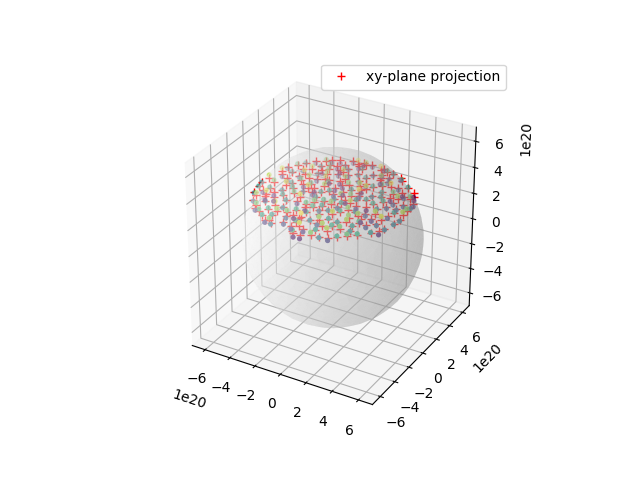

<IPython.core.display.Javascript object>


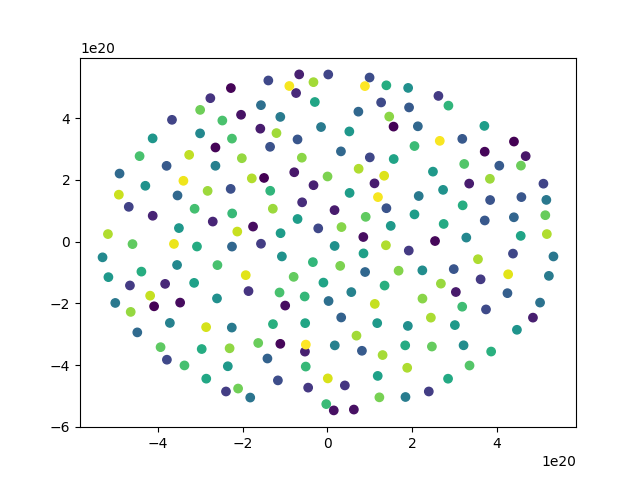

In [47]:
mesh_plane = plt.figure()
plot_mesh_slice(20, mesh_plane, height = 10*kp, portion = True, cross_section=True)

## Defining a function to plot a trisurf graph of a slice of the domain, here the xy axis

In [30]:
def trisurf_function_slice(figure, function, amount, height):
    '''Plot a trisurf along a plane (currently only the xy-plane) of a given function. The slice
    of points defining the xy plane is obtained from the slice_mesh function
    '''
    
    #Obtaining the x,y coordinates and functions to plot from slice_mesh
    x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount = (slice_mesh(amount,
                                            mesh, height, True, True, function))
    
    #Adding a subplot to the figure input
    plane_trisurf = figure.add_subplot(111, projection='3d')

    plane_trisurf.plot_trisurf(x_xy_plane, y_xy_plane, function_xy_plane, cmap = 'jet')

<IPython.core.display.Javascript object>


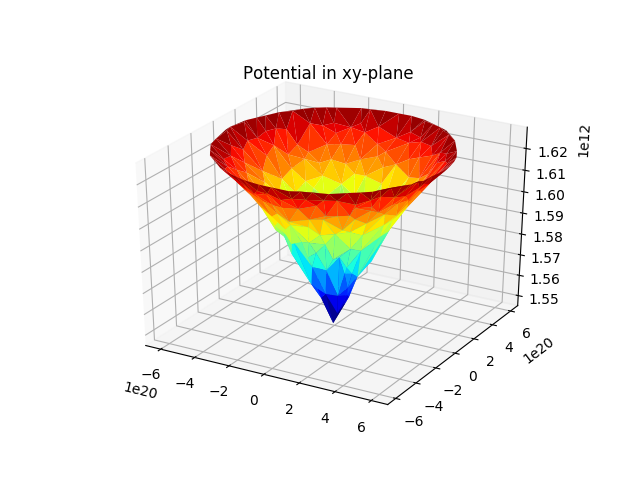

Text(0.5, 0.92, 'Potential in xy-plane')

In [31]:
trisurf_potential = plt.figure()
trisurf_function_slice(trisurf_potential, potential, 20, 5*kp)
plt.title('Potential in xy-plane')

<IPython.core.display.Javascript object>


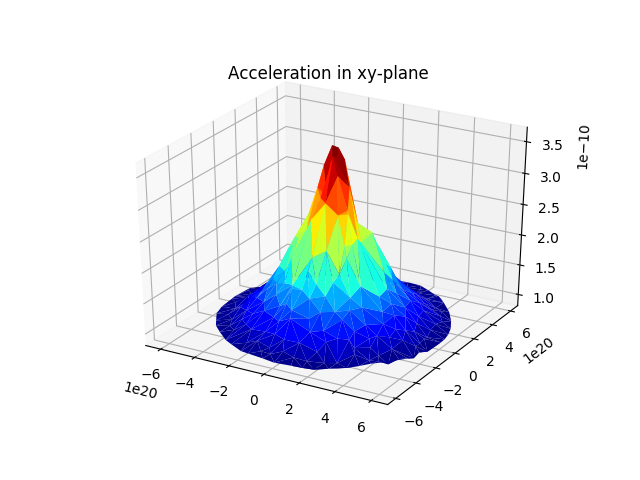

Text(0.5, 0.92, 'Acceleration in xy-plane')

In [32]:
trisurf_acceleration = plt.figure()
trisurf_function_slice(trisurf_acceleration, acceleration_magnitude, 20, 5*kp)
plt.title('Acceleration in xy-plane')

<IPython.core.display.Javascript object>


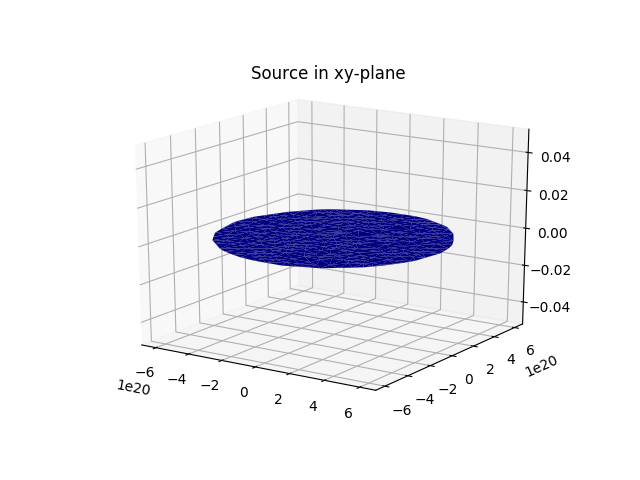

Text(0.5, 0.92, 'Source in xy-plane')

In [33]:
trisurf_source = plt.figure()
trisurf_function_slice(trisurf_source, source, 20, 5*kp)
plt.title('Source in xy-plane')

## Plotting contour lines of the potential, so we can do that for different values of z and see the whole domain.

In [34]:
def tricontour_function_slice(figure, function, amount, levels, height):
    '''Plot a trisurf along a plane (currently only the xy-plane) of a given function. The slice
    of points defining the xy plane is obtained from the slice_mesh function
    '''
    
    #Obtaining the x,y coordinates and functions to plot from slice_mesh
    x_xy_plane, y_xy_plane, z_xy_plane, function_xy_plane, amount = (slice_mesh(amount,
                                            mesh, height, True, True, function))
    
    #Adding a subplot to the figure input. Not adding the projection = 3d option so we have it 
    #all in one plane and can plot multiple for e.g. different values of z
    plane_trisurf = figure.add_subplot(111)

    plane_trisurf.tricontour(x_xy_plane, y_xy_plane, function_xy_plane, levels, cmap = 'jet')

<IPython.core.display.Javascript object>


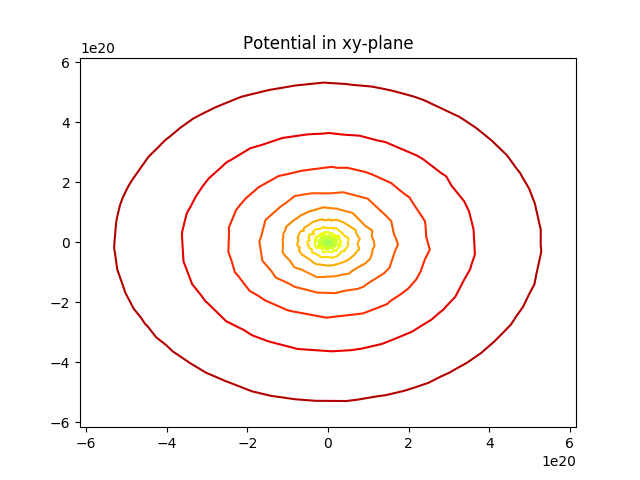

Text(0.5, 1.0, 'Potential in xy-plane')

In [35]:
#HAVE TO ADJUST THIS! ALL WORKS OOD BUT HAD TO LEAVE AND NEED TO ORDER THE INPUTS CORRECTLY FROM THE 
#MESH SLICE FUNCTION I CHANGED!


tricontour_potential = plt.figure()
tricontour_function_slice(tricontour_potential, potential, 20, 20, 0)
plt.title('Potential in xy-plane')

<IPython.core.display.Javascript object>


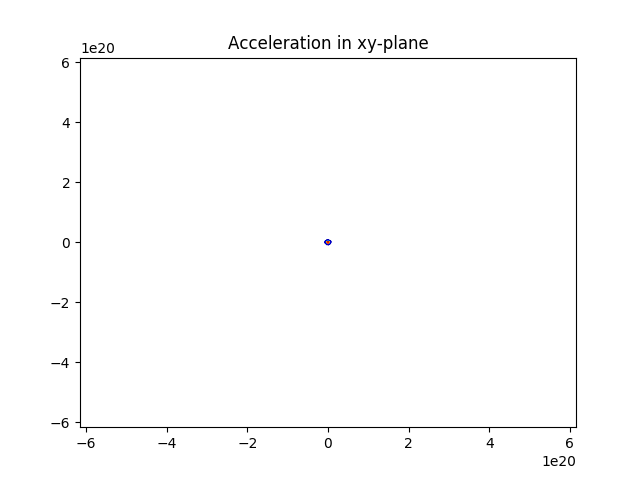

Text(0.5, 1.0, 'Acceleration in xy-plane')

In [36]:
trisurf_acceleration = plt.figure()
tricontour_function_slice(trisurf_acceleration, acceleration_magnitude, 20, 20, 0)
plt.title('Acceleration in xy-plane')

<IPython.core.display.Javascript object>


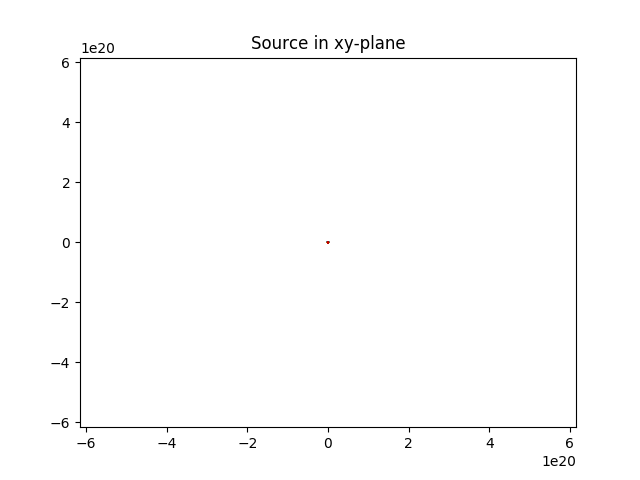

Text(0.5, 1.0, 'Source in xy-plane')

In [37]:
trisurf_source = plt.figure()
tricontour_function_slice(trisurf_source, source, 20, 20, 0)
plt.title('Source in xy-plane')

# Trying to construct mesh through MeshEditor

In [38]:
# domain_trial = mshr.Sphere(origin, domain_size)
# mesh_trial = mshr.generate_mesh(domain_trial, 21)
# # mesh_trial

In [39]:
# #Initialising a MeshEditor object
# mesh_edit = MeshEditor()

# #Opening an existing mesh with MeshEditor. Need to specify the cell name (string, 'tetrahedron'),
# #the topological dimension (not sure what it is!) and geometrical dimensions (3)
# mesh_edit.open(mesh_trial,mesh_trial.cell_name(), 3,3)

# #Generating three coordinate vectors to make a grid
# x_grid = np.linspace(0,1,10)
# y_grid = x_grid.copy()
# z_grid = x_grid.copy()

# #Making a 3D grid and assigning the grid values to three variables
# X, Y, Z = np.meshgrid(x_grid, y_grid, z_grid)

# #Flattening each coordinate array (ravel), then stacking them vertically, so that we now 
# #have an nd.array with 3 rows (one per coordinate, XYZ), and n columns, one per point
# #Stacked in this order to get the correct order in the array for checking correctness
# positions = np.vstack([Y.ravel(), X.ravel(), Z.ravel()])

# #Transposing the 3*n matrix into an n*3 matrix so we can use a list comprehension to assign 
# #point, as now positions[0] will give the three coordinate values instead of all n x-values!
# positions = positions.transpose()

# #List comprehension to make a list of points with coordinates from 'positions'
# grid_points = [Point(coordinates) for coordinates in positions]

# #Getting the amount of grid points
# grid_vertex_number = len(grid_points)

# #Declaring the amount of vertices in the mesh. Have to do this before adding any vertex!
# #This limits the available vertex indices, so if you try to add more than you declared, you
# #get an error!
# mesh_edit.init_vertices(grid_vertex_number)

# #Adding the vertices in grid_points to the mesh
# [mesh_edit.add_vertex(i,point) for i, point in enumerate(grid_points)]

# mesh_edit.close()

# mesh_trial.num_vertices()
# # mesh_trial.coordinates()

# #IMPORTANT: The problem with the MeshEditor is that it is not sufficient to define the vertices
# #One also has to define the cells! Need to look for a function that does that automatically
# #possibly with a Delaunay triangulation!

## Plotting the times taken by each section to profile the code

<IPython.core.display.Javascript object>


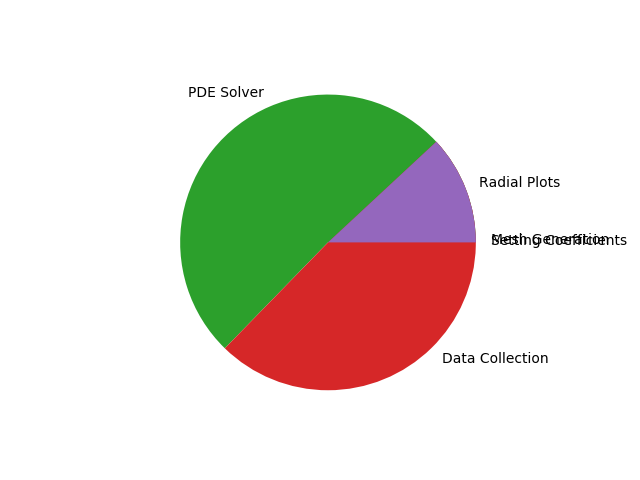

([<matplotlib.patches.Wedge at 0x7f72c15996d8>,
 [Text(1.099972007420992, 0.007847476679363165, 'Setting Coefficients'),
  Text(1.0998775668714296, 0.016411517083567806, 'Mesh Generation'),
  Text(-0.4355075303272773, 1.0101154345064904, 'PDE Solver'),
  Text(0.7687387685310317, -0.7867913991379119, 'Data Collection'),
  Text(1.0237541526101828, 0.40240208127370186, 'Radial Plots')])

In [40]:
plt.figure()
pie_name = [section.name for section in section_times]
pie_time = np.zeros((len(section_times),1))

#can't use a list comprehension as for pie_name to make a numpy array, cause it makes
#a list instead! and for numbers it's always best to work with numpy 
for i, section in enumerate(section_times):
    pie_time[i] = section.time
    
#percentage of time taken, to display on the pie chart
pie_time_percent = [pie_time/(pie_time.sum()*100)]

#plotting the pie chart
plt.pie(pie_time, labels = pie_name)
# plt.legend()

In [41]:
pie_time = np.zeros((len(section_times),1))

In [42]:
# mesh